- **Describe your fraud detection model in elaboration**

- After careful analysis of the dataset provided, I found out that it is very much imbalanced, I performed EDA to understand the *corelation* and features like **amount**, **oldbalanceOrg** and **step** were found to be crucial.
- Used *Standard Scaler* and *Label Encoding* to scale and encode the dataset, followed by using K-Fold split for spliting it in Train and Validation Dataset for cross-validation
- Since the dataset is hugely imbalanced decided to run comparison between **Logistic Regression**, **Random Forest** and **XGBoost Classifier** and found that *XGBoost Classifier* outperformed all the three, thus performed Hyperparameter-Tuning of the model.
- The model gave **99.00%** Accuracy on Validation Dataset, formed using K-Fold split.

- **What kind of prevention should be adopted while company update its infrastructure?**

- Usually considerable amounts led to fraud, thus company should put a upper limit to tranction amount, also it was seen that much frauds occured in **'Transfer'** type, thus it is adviced to allow only those clients who have been not flagged at all by the system

- **Assuming these actions have been implemented, how would you determine if they work?**

- Constant study of the model and frequently training the model on new dataset will be great help to encounter frauds, since the percentage of fraud is very less as compared to dataset, even 1% drop in accurancy is enough to notify the team so that it could be updated, because 1% drop leads to a huge increament in fraud transactions

In [1]:
import numpy as np 
import pandas as pd 
import random
import tensorflow as tf
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv("Fraud.csv")
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [3]:
df.isFraud.value_counts(normalize=True)

isFraud
0    0.998709
1    0.001291
Name: proportion, dtype: float64

In [3]:
df.drop('isFlaggedFraud', axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 10 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
dtypes: float64(5), int64(2), object(3)
memory usage: 485.4+ MB


In [4]:
fraud_min_max = [
    ['amount', df.amount.min(), df.amount.max()],
    ['oldbalanceOrg', df.oldbalanceOrg.min(), df.oldbalanceOrg.max()],
    ['newbalanceOrig', df.newbalanceOrig.min(), df.newbalanceOrig.max()],
    ['oldbalanceDest', df.oldbalanceDest.min(), df.oldbalanceDest.max()],
    ['isFraud', df.isFraud.min(), df.isFraud.max()]
] 

fraud_min_max

[['amount', 0.0, 92445516.64],
 ['oldbalanceOrg', 0.0, 59585040.37],
 ['newbalanceOrig', 0.0, 49585040.37],
 ['oldbalanceDest', 0.0, 356015889.35],
 ['isFraud', 0, 1]]

In [5]:
for col in df.columns:
    if df[col].dtype == 'float64':
        df[col] = pd.to_numeric(df[col], downcast='float')
    if df[col].dtype == 'int64':
        df[col] = pd.to_numeric(df[col], downcast='unsigned')

# Use category dtype for categorical column
df['type'] = df['type'].astype('category')

In [6]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
dtype: int64

- **Data cleaning including missing values, outliers and multi-collinearity**
- As it can been seen that data given has no missing values
- The *fraud_min_max* handles the ouliers

In [7]:
df['type'].value_counts()

type
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: count, dtype: int64

In [8]:
df['step'].value_counts()

step
19     51352
18     49579
187    49083
235    47491
307    46968
       ...  
432        4
706        4
693        4
112        2
662        2
Name: count, Length: 743, dtype: int64

In [9]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00


# Exploratory Data Analysis

In [10]:
sns.set_style('darkgrid')
plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.facecolor'] = '#00000000'

In [14]:
fig = px.histogram(df.sample(5000), 
                   x='amount', 
                   marginal='box', 
                   color='type',
                   color_discrete_sequence=['red','blue','green','black','grey'], 
                   title='Amount and Mode of Payment')
fig.update_layout(bargap=0.1)
fig.show()

In [15]:
fig = px.histogram(df.sample(15000), 
                   x='type', 
                   marginal='box', 
                   color='isFraud',
                   color_discrete_sequence=['red','blue'], 
                   title='Mode of Payment and Fraud')
fig.update_layout(bargap=0.1)
fig.show()

(3500.0, 7000.0)

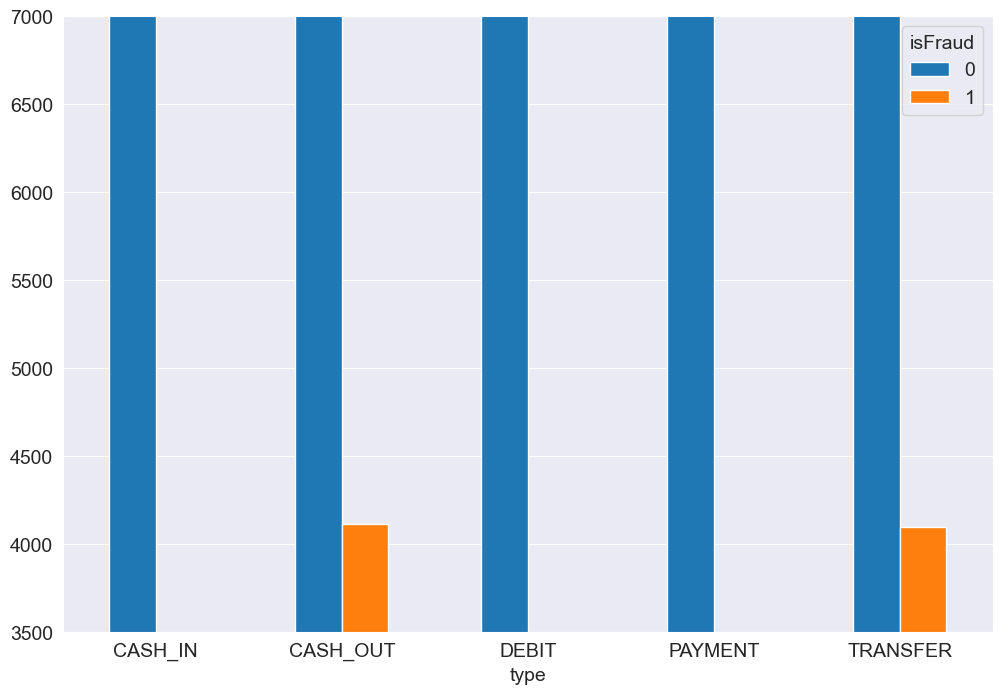

In [16]:
CrosstabResult=pd.crosstab(index=df.type,columns=df.isFraud)
CrosstabResult.plot.bar(figsize=(12,8), rot=0)
plt.ylim([3500, 7000])

In [17]:
CrosstabResult

isFraud,0,1
type,,
CASH_IN,1399284,0
CASH_OUT,2233384,4116
DEBIT,41432,0
PAYMENT,2151495,0
TRANSFER,528812,4097


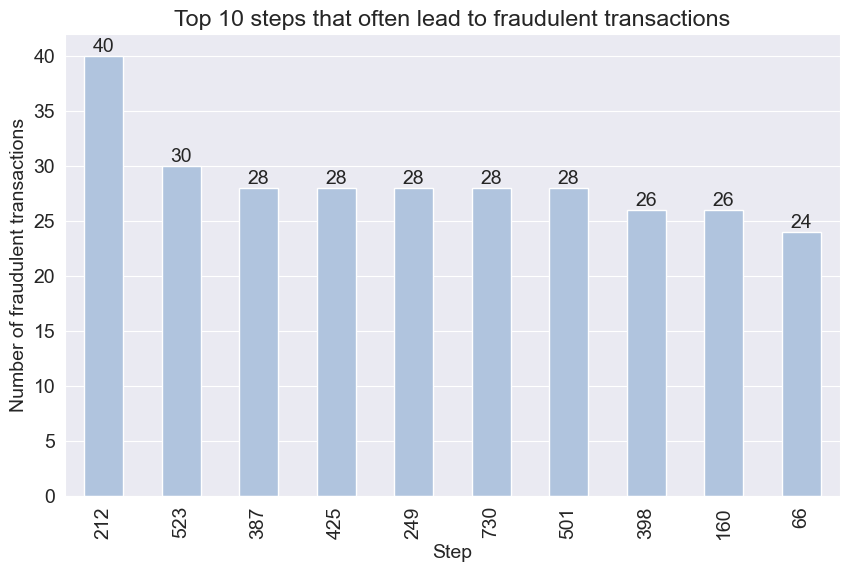

In [18]:
df1 = df[df['isFraud']==1]
df2 = df1['step'].value_counts().head(10)
ax = df2.plot(kind='bar', color='lightsteelblue')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Top 10 steps that often lead to fraudulent transactions')
plt.ylabel('Number of fraudulent transactions')
plt.xlabel('Step')
plt.grid(axis='x')

del ax, df2

In [20]:
fig = px.scatter(df.sample(15000), 
                 x='newbalanceDest', 
                 y='oldbalanceDest', 
                 color='isFraud', 
                 opacity=0.8, 
                 hover_data=['isFraud'], 
                 title='New Balance Dest vs. Old Balance Dest')
fig.update_traces(marker_size=5)
fig.show()

In [21]:
fig = px.scatter(df.sample(15000), 
                 x='newbalanceOrig', 
                 y='oldbalanceOrg', 
                 color='isFraud', 
                 opacity=0.8, 
                 hover_data=['isFraud'], 
                 title='New Balance Orig vs. Old Balance Org')
fig.update_traces(marker_size=5)
fig.show()

Text(0.5, 1.0, 'Correlation')

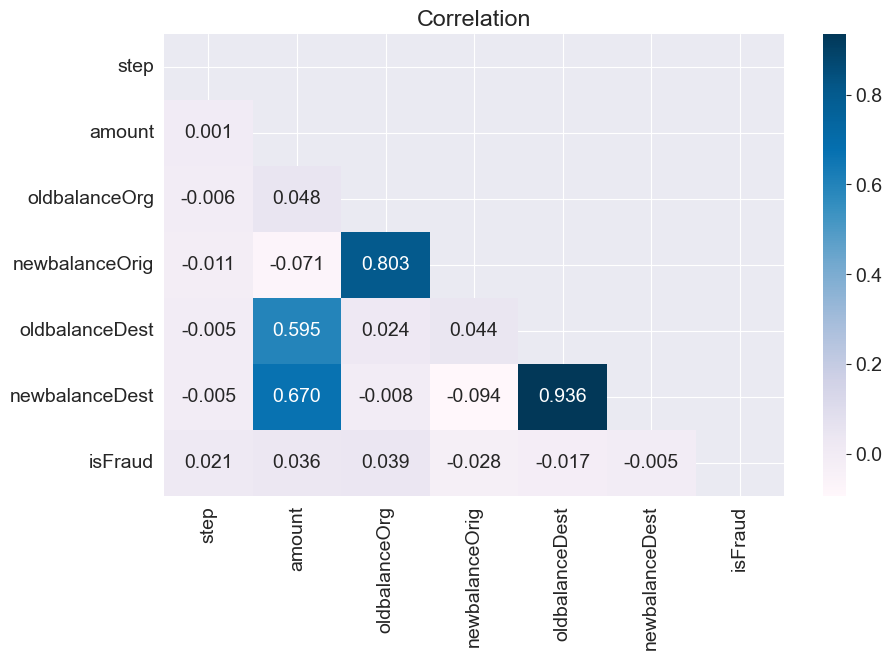

In [22]:
corr_matrix = df.corr('spearman', numeric_only=True)
sns.heatmap(corr_matrix, cbar=True, annot=True, mask = np.triu(np.ones_like(corr_matrix, dtype = bool)), fmt='.3f', cmap='PuBu')
plt.title('Correlation')

# Preprocessing and Feature Engineering

In [23]:
df['type'] = df['type'].map({'PAYMENT':0, 'CASH_IN':1, 'DEBIT':2, 'CASH_OUT':3, 'TRANSFER':4})

In [24]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,1,0,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0
1,1,0,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0
2,1,4,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1
3,1,3,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1
4,1,0,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0


In [25]:
''' Demonstration of performance of model by using classification_report, roc_curve, auc, ConfusionMatrixDisplay, accuracy_score, confusion_matrix'''

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, roc_curve, auc, ConfusionMatrixDisplay, accuracy_score, confusion_matrix

seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)


X = df.copy()
X.drop(['nameOrig', 'nameDest'], axis=1, inplace=True)
y = X.pop('isFraud')


# Stratified train-test split
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
for train_idx, test_idx in skfold.split(X,y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]


sc = StandardScaler()
scaled_train = sc.fit_transform(X_train)
scaled_test = sc.transform(X_test)
X_train = pd.DataFrame(scaled_train, index=X_train.index, columns=X_train.columns)
X_test = pd.DataFrame(scaled_test, index=X_test.index, columns=X_test.columns)


X_train, y_train = RandomUnderSampler(sampling_strategy='majority').fit_resample(X_train, y_train)

# XGBoost Classifier Model Training

- **How did you select variables to be included in the model?**

- After several iterations of model and through study of XGBoost CLassifier parameters I came to conclusion that **random_state**=seed(set as 42), **n_estimators=500**(idle), **learning_rate=0.07**(after several iterations this value was attained), **max_depth=10**(after several iterations this value was attained), **grow_policy** = 'depthwise'(from through study of XGBoost CLassifier parameters), **colsample_bytree = 0.9**, **colsample_bylevel = 0.9**, **colsample_bynode =0.9**, **importance_type='weight'**, **base_score=0.7**, **booster='gbtree'**, **n_jobs=-1** are the near perfect values to attain the accuracy of *99.00%*

XGBClassifier:
               precision    recall  f1-score   support

Non-Fraud [0]       0.99      1.00      0.99   1258162
    Fraud [1]       1.00      0.11      0.20     14362

     accuracy                           0.99   1272524
    macro avg       0.99      0.56      0.60   1272524
 weighted avg       0.99      0.99      0.99   1272524
 



Text(0.5, 0, 'False Positive Rate')

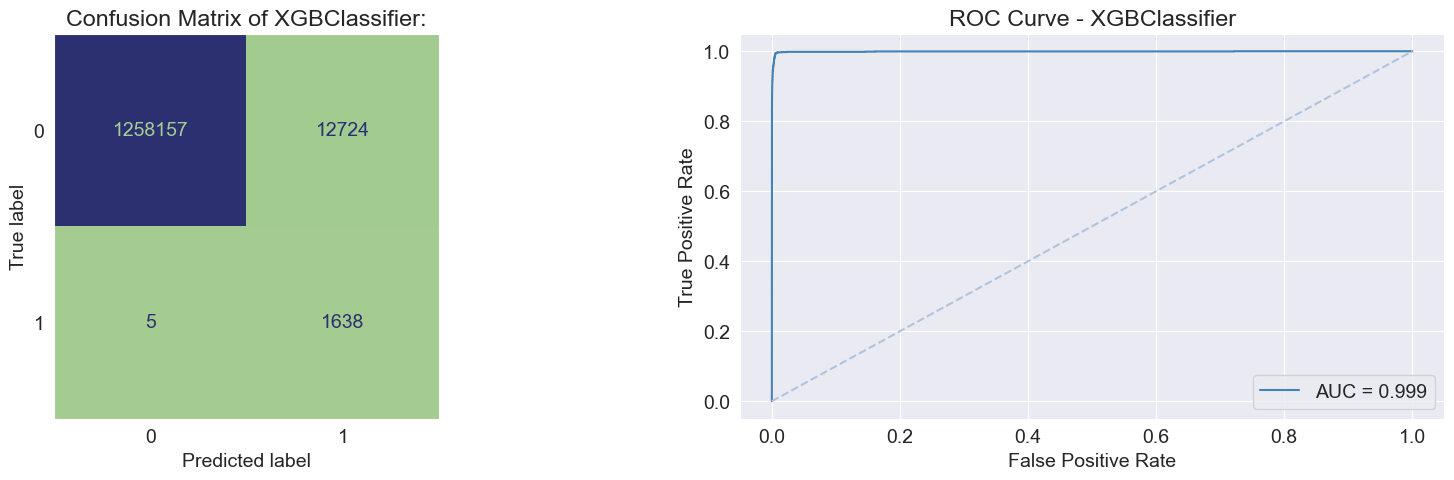

In [26]:
model = XGBClassifier(random_state=seed, n_estimators=500, learning_rate=0.07,
                       max_depth=10, grow_policy = 'depthwise', 
                      colsample_bytree = 0.9, colsample_bylevel = 0.9, colsample_bynode =0.9, 
                      importance_type='weight', base_score=0.7,
                      booster='gbtree', n_jobs=-1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_score = model.predict_proba(X_test)[:,1]
print('XGBClassifier:')
print(classification_report(y_pred, y_test, labels=[0,1], target_names=['Non-Fraud [0]', 'Fraud [1]']), '\n')



fig, ax = plt.subplots(1, 2, figsize=(20,5))
ax[0].set_title('Confusion Matrix of XGBClassifier:')
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, colorbar=False, values_format='', cmap='crest', ax=ax[0])
ax[0].grid(False)



fpr, tpr, thresholds = roc_curve(y_test, y_pred_score)
roc_auc = auc(fpr, tpr)                       
ax[1].set_title('ROC Curve - XGBClassifier')
ax[1].plot(fpr, tpr, label = 'AUC = %0.3f' % roc_auc, c='steelblue')
ax[1].plot([0,1],[0,1],'--', c='lightsteelblue')
ax[1].legend(loc='lower right')
ax[1].set_ylabel('True Positive Rate')
ax[1].set_xlabel('False Positive Rate')

# Train-Validation Accuracy Score

In [27]:
def predict_and_plot(inputs, targets, name=''):
    preds = model.predict(inputs)
    
    accuracy = accuracy_score(targets, preds)
    print("Accuracy: {:.2f}%".format(accuracy * 100))
    # print('Train Predictions: {}, True Train Predictions: {}'.format(len(targets)-accuracy*len(targets)*0.01,targets.value_counts()))
    
    cf = confusion_matrix(targets, preds, normalize='true')
    plt.figure()
    sns.heatmap(cf, annot=True)
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name));
    
    return preds

Accuracy: 100.00%


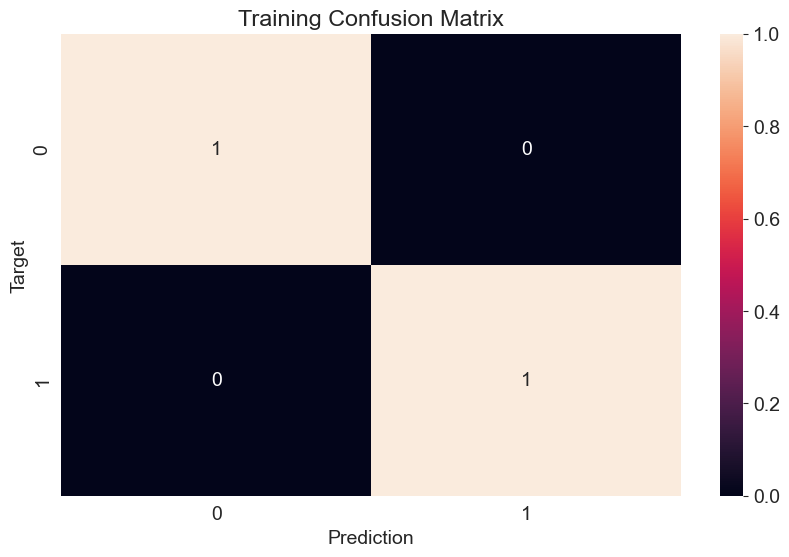

In [28]:

train_preds = predict_and_plot(X_train, y_train, 'Training')

Accuracy: 99.00%


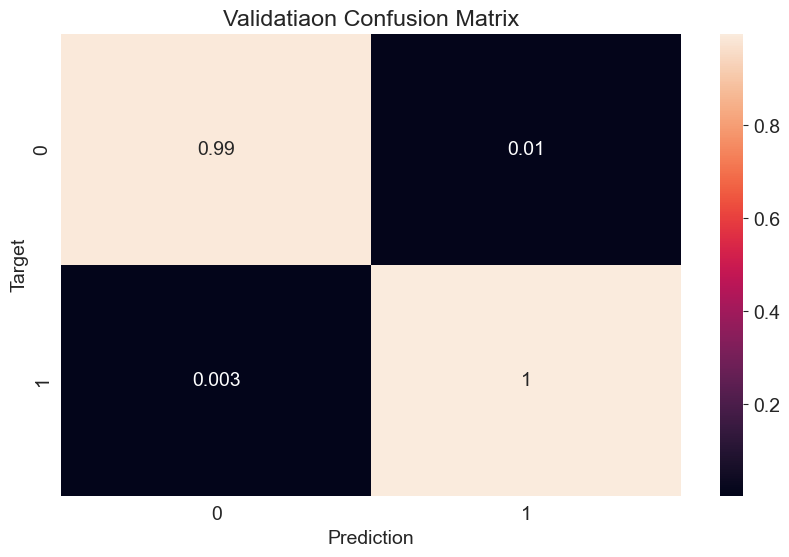

In [29]:
val_preds = predict_and_plot(X_test, y_test, 'Validatiaon')

# Feature Importance

In [31]:
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

importance_df

,feature,importance
2,amount,0.248692
3,oldbalanceOrg,0.219381
0,step,0.192975
6,newbalanceDest,0.142655
5,oldbalanceDest,0.137756
1,type,0.029727
4,newbalanceOrig,0.028813


- **What are the key factors that predict fraudulent customer?**

- Using Feature Importance to identify the key factors: It was found that *amount*, *oldbalanceOrg*, *step*, *newbalanceDest* and *oldbalanceDest* play crucial part in prediciton!

- **Do these factors make sense? If yes, How? If not, How not?**

- Yes, they make complete sense, they are in total sync with that attained via EDA, these features were seen to be crucial in fraud detection in EDA and feature importance proved this hypothesis.

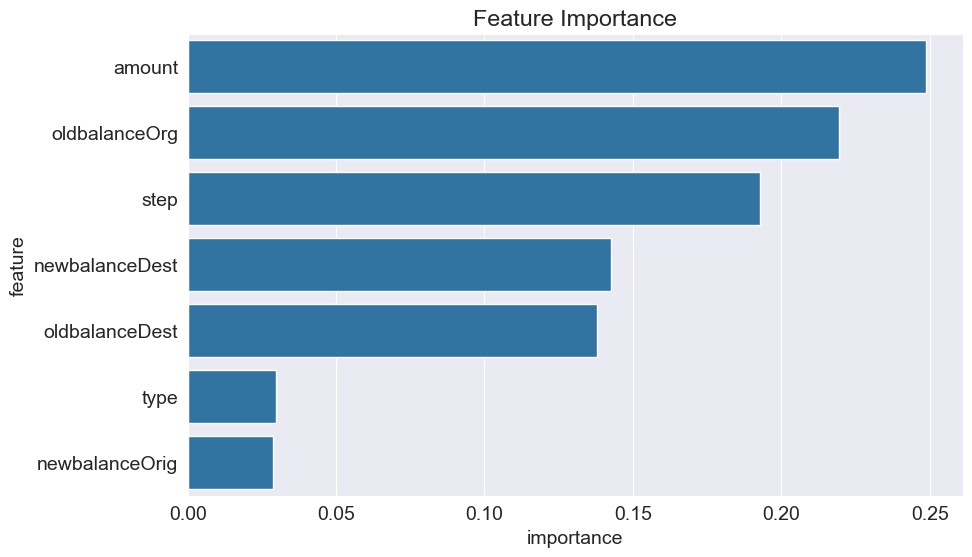

In [33]:
plt.title('Feature Importance')
sns.barplot(importance_df, x='importance', y='feature');